<a href="https://colab.research.google.com/github/Shiva007-RAndom/App/blob/main/Runverve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Description of model**
I have created synthetic data sets with features as artist ID, Gender, age, height, weight, training intensity, training hours per week, recovery days per week, match count per week, rest between event days and fatigue score.
Plots are used to visualize the data ,find outliers if any.  
The data is then pre-processed with appropriate tendencies.  
Then a XGBRegressor model is then trained on these data. Hyperparameters are then fine tuned to get the best r2 score.

# **Creating Synthetic Data**

In [ ]:
import pandas as pd
import numpy as np

np.random.seed(42)
n = 1500

df = pd.DataFrame({
    'Artist_ID' : [f"A{i:04d}" for i in range(n)],
    'Gender': np.random.choice(['Male', 'Female'], size=n),
    'Age': np.random.randint(18, 40, size=n),
    'Height_cm': np.random.normal(175, 10, size=n),
    'Weight_kg': np.random.normal(70, 15, size=n),
    'Training_Intensity': np.random.uniform(0.5, 1.0, size=n),
    'Training_Hours_Per_Week': np.random.randint(3, 15, size=n),
    'Recovery_Days_Per_Week': np.random.randint(0, 4, size=n),
    'Match_Count_Per_Week': np.random.randint(0, 5, size=n),
    'Rest_Between_Events_Days': np.random.randint(1, 7, size=n)
})

gender_effect = np.where(df['Gender'] == 'Male', 1.0, 0.5)
df['Fatigue_Score'] = (
    0.3 * df['Training_Hours_Per_Week'] +
    0.5 * df['Training_Intensity'] * 10 +
    0.2 * df['Match_Count_Per_Week'] -
    0.4 * df['Recovery_Days_Per_Week'] -
    0.2 * df['Rest_Between_Events_Days'] +
    gender_effect +
    np.random.normal(0, 0.3, size=n)  # noise
).round(2)
num_missing = int(0.03 * n)
missing_indices = np.random.choice(df.index, size=num_missing, replace=False)
df.loc[missing_indices, 'Training_Intensity'] = np.nan

df.head()


,Artist_ID,Gender,Age,Height_cm,Weight_kg,Training_Intensity,Training_Hours_Per_Week,Recovery_Days_Per_Week,Match_Count_Per_Week,Rest_Between_Events_Days,Fatigue_Score
0,A0000,Male,36,174.632237,70.287324,0.601427,5,1,1,6,4.02
1,A0001,Female,23,164.847866,73.445511,0.999159,3,0,4,3,6.62
2,A0002,Male,23,175.409868,49.174148,0.770681,7,3,2,5,5.24
3,A0003,Male,20,183.294739,66.740745,0.642029,6,3,3,4,4.86
4,A0004,Male,24,164.263710,62.540986,0.997387,4,2,3,3,6.61


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Artist_ID                 1500 non-null   object 
 1   Gender                    1500 non-null   object 
 2   Age                       1500 non-null   int64  
 3   Height_cm                 1500 non-null   float64
 4   Weight_kg                 1500 non-null   float64
 5   Training_Intensity        1455 non-null   float64
 6   Training_Hours_Per_Week   1500 non-null   int64  
 7   Recovery_Days_Per_Week    1500 non-null   int64  
 8   Match_Count_Per_Week      1500 non-null   int64  
 9   Rest_Between_Events_Days  1500 non-null   int64  
 10  Fatigue_Score             1500 non-null   float64
dtypes: float64(4), int64(5), object(2)
memory usage: 129.0+ KB


In [ ]:
df.drop('Artist_ID',axis=1,inplace=True)

In [ ]:
df.head()

,Gender,Age,Height_cm,Weight_kg,Training_Intensity,Training_Hours_Per_Week,Recovery_Days_Per_Week,Match_Count_Per_Week,Rest_Between_Events_Days,Fatigue_Score
0,Male,36,174.632237,70.287324,0.601427,5,1,1,6,4.02
1,Female,23,164.847866,73.445511,0.999159,3,0,4,3,6.62
2,Male,23,175.409868,49.174148,0.770681,7,3,2,5,5.24
3,Male,20,183.294739,66.740745,0.642029,6,3,3,4,4.86
4,Male,24,164.263710,62.540986,0.997387,4,2,3,3,6.61


<Axes: xlabel='Gender', ylabel='Fatigue_Score'>

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


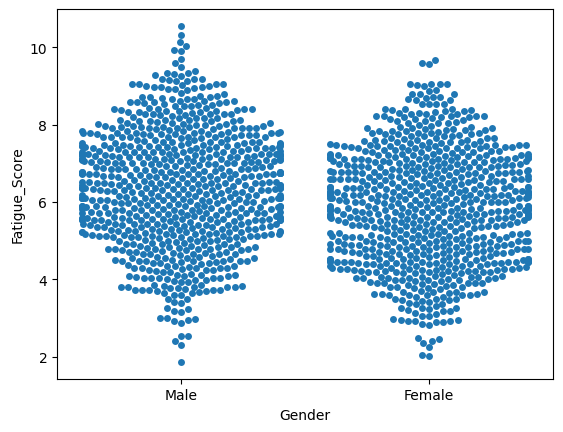

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.swarmplot(x='Gender',y='Fatigue_Score',data=df)

# **Data Pre-processing**


In [ ]:
#Check for missing values
df.isnull().sum()

,0
Gender,0
Age,0
Height_cm,0
Weight_kg,0
Training_Intensity,45
Training_Hours_Per_Week,0
Recovery_Days_Per_Week,0
Match_Count_Per_Week,0
Rest_Between_Events_Days,0
Fatigue_Score,0


In [ ]:
#Missing values in Training intensity are filled
df['Training_Intensity'].fillna(df['Training_Intensity'].median(),inplace=True)

<ipython-input-60-2b3b18326c99>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Training_Intensity'].fillna(df['Training_Intensity'].median(),inplace=True)


## **Data Analysis**

In [ ]:
cols=df.columns.tolist()

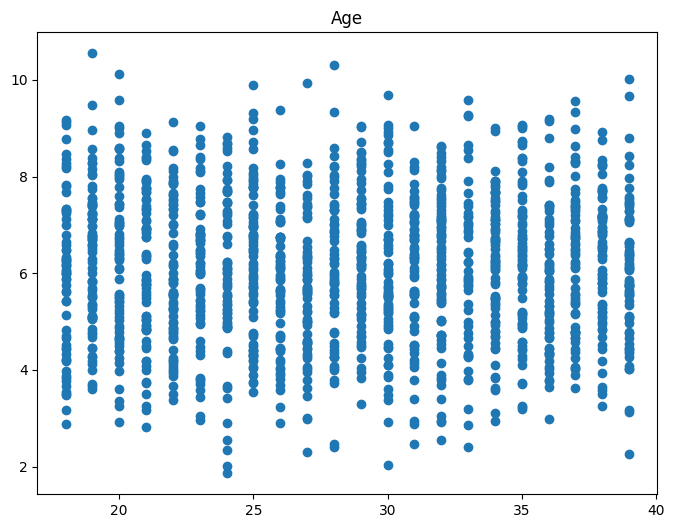

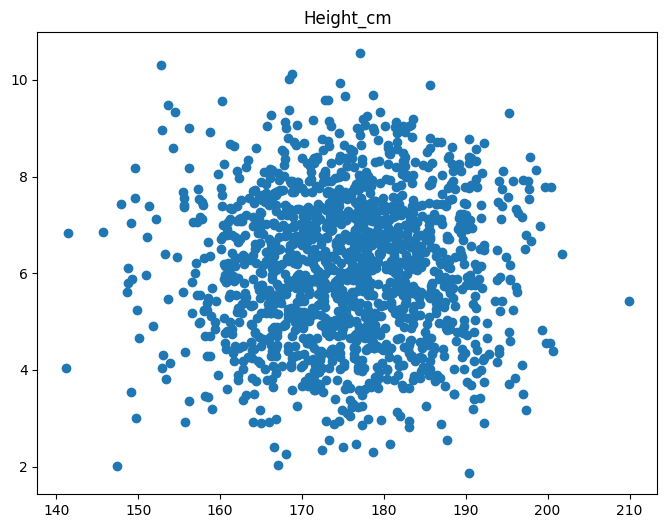

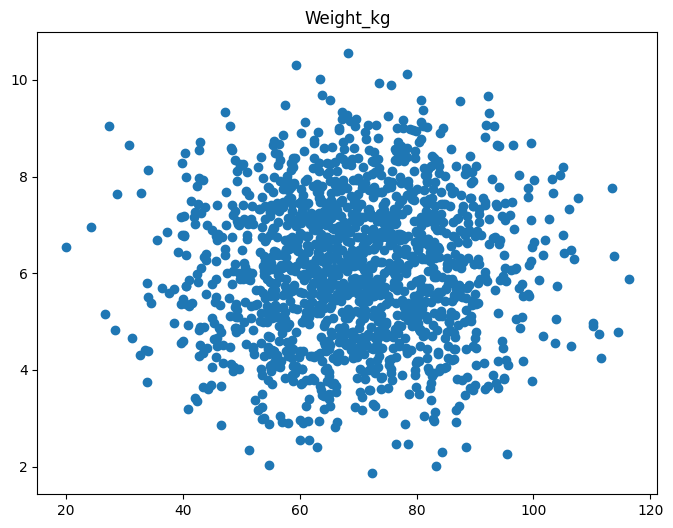

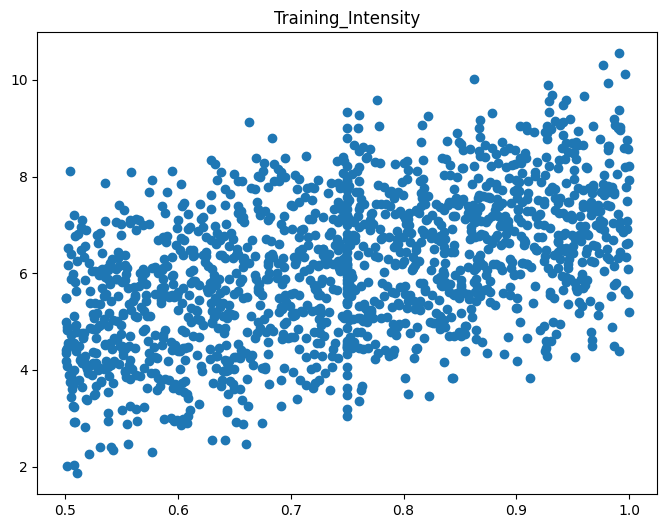

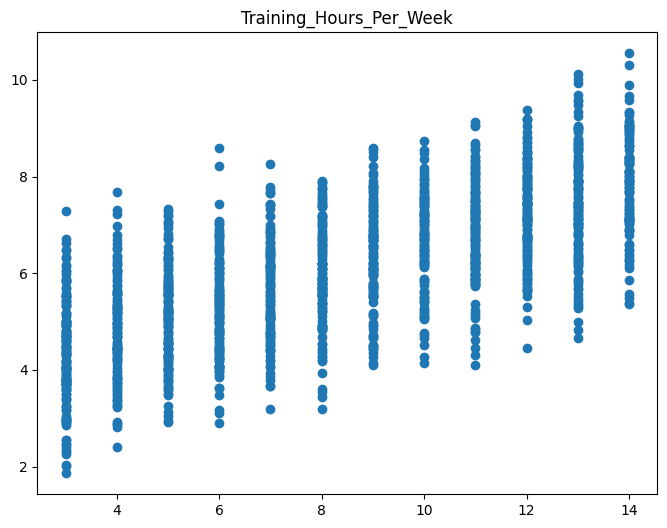

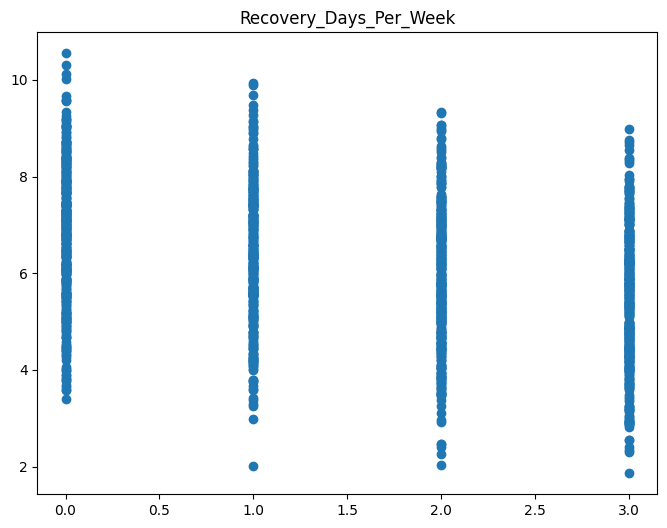

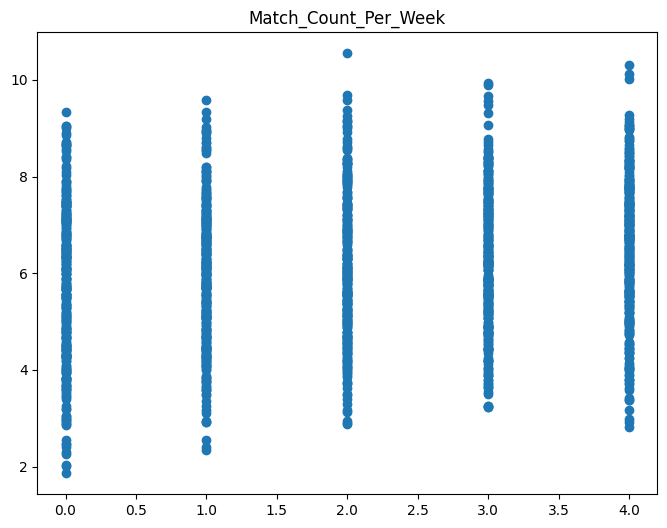

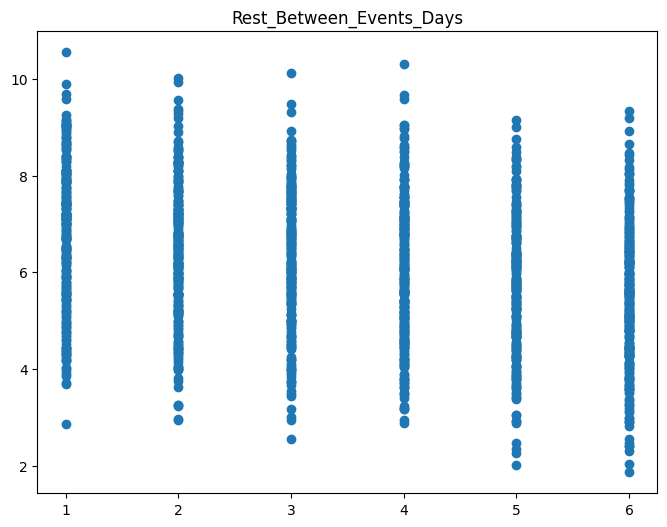

In [ ]:

for col in cols[1:len(cols)-1]:
  plt.figure(figsize=(8,6))
  plt.scatter(df[col],df['Fatigue_Score'])
  plt.title(col)
  plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Gender                    1500 non-null   object 
 1   Age                       1500 non-null   int64  
 2   Height_cm                 1500 non-null   float64
 3   Weight_kg                 1500 non-null   float64
 4   Training_Intensity        1500 non-null   float64
 5   Training_Hours_Per_Week   1500 non-null   int64  
 6   Recovery_Days_Per_Week    1500 non-null   int64  
 7   Match_Count_Per_Week      1500 non-null   int64  
 8   Rest_Between_Events_Days  1500 non-null   int64  
 9   Fatigue_Score             1500 non-null   float64
dtypes: float64(4), int64(5), object(1)
memory usage: 117.3+ KB


<Axes: >

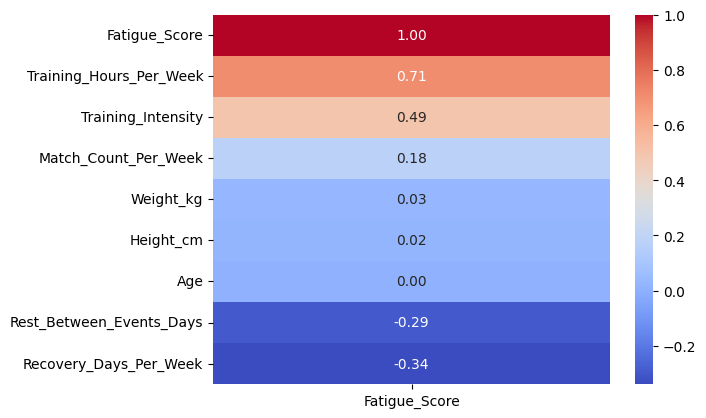

In [ ]:
#Heatmap
corr = df.corr(numeric_only=True)[['Fatigue_Score']].sort_values(by='Fatigue_Score', ascending=False)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

In [ ]:
#One Hot Encoding
df = pd.get_dummies(df,columns=['Gender'],dtype='float64')


In [ ]:
df.head()

,Age,Height_cm,Weight_kg,Training_Intensity,Training_Hours_Per_Week,Recovery_Days_Per_Week,Match_Count_Per_Week,Rest_Between_Events_Days,Fatigue_Score,Gender_Female,Gender_Male
0,36,174.632237,70.287324,0.601427,5,1,1,6,4.02,0.0,1.0
1,23,164.847866,73.445511,0.999159,3,0,4,3,6.62,1.0,0.0
2,23,175.409868,49.174148,0.770681,7,3,2,5,5.24,0.0,1.0
3,20,183.294739,66.740745,0.642029,6,3,3,4,4.86,0.0,1.0
4,24,164.263710,62.540986,0.997387,4,2,3,3,6.61,0.0,1.0


## **Training Model**

[0]	validation_0-rmse:5.86544
[1]	validation_0-rmse:5.81023
[2]	validation_0-rmse:5.75543
[3]	validation_0-rmse:5.70100
[4]	validation_0-rmse:5.64731
[5]	validation_0-rmse:5.59428
[6]	validation_0-rmse:5.54151
[7]	validation_0-rmse:5.48958
[8]	validation_0-rmse:5.43788
[9]	validation_0-rmse:5.38666
[10]	validation_0-rmse:5.33603
[11]	validation_0-rmse:5.28573
[12]	validation_0-rmse:5.23597
[13]	validation_0-rmse:5.18631
[14]	validation_0-rmse:5.13794
[15]	validation_0-rmse:5.08928
[16]	validation_0-rmse:5.04182
[17]	validation_0-rmse:4.99412
[18]	validation_0-rmse:4.94753
[19]	validation_0-rmse:4.90081
[20]	validation_0-rmse:4.85432
[21]	validation_0-rmse:4.80923
[22]	validation_0-rmse:4.76396
[23]	validation_0-rmse:4.71996
[24]	validation_0-rmse:4.67526
[25]	validation_0-rmse:4.63177
[26]	validation_0-rmse:4.58788
[27]	validation_0-rmse:4.54564
[28]	validation_0-rmse:4.50286
[29]	validation_0-rmse:4.46117
[30]	validation_0-rmse:4.41976
[31]	validation_0-rmse:4.37816
[32]	validation_0-

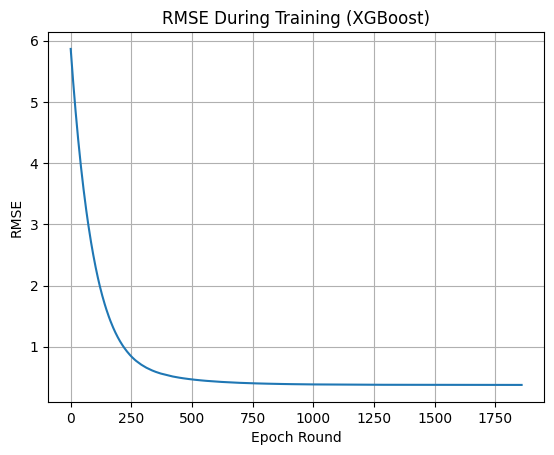

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

x=df.drop(columns=['Fatigue_Score','Age','Height_cm','Weight_kg'])
y=df['Fatigue_Score']
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3,random_state=42)

model=XGBRegressor(max_depth=3,n_estimators=2500,learning_rate=0.01,reg_alpha=1,reg_lambda=1,early_stopping_rounds=10)
model.fit(xtrain,ytrain,eval_set=[(xtest,ytest)])

#early stopping rounds to prevent overfitting
results = model.evals_result()

# Plot test RMSE over epoch rounds
plt.plot(results['validation_0']['rmse'])
plt.xlabel("Epoch Round")
plt.ylabel("RMSE")
plt.title("RMSE During Training (XGBoost)")
plt.grid(True)
plt.show()

In [ ]:
#prediction on test set
ypred=model.predict(xtest)
print(r2_score(ytest,ypred)*100)

94.09601851348735


In [ ]:
#prediction on training set
ycap=model.predict(xtrain)
print(r2_score(ytrain,ycap)*100)

96.52425002354803
